https://www.dataquest.io/m/257/guided-project%3A-analyzing-cia-factbook-data-using-sqlite-and-python

The dataset used in this project is from the [The World Factbook of CIA](https://www.cia.gov/library/publications/the-world-factbook/). Specifically, I will use `factbook.db` downloaded from https://github.com/factbook/factbook.sql/releases.

# 1. Overview of the Data

Let's first get information on table.

In [1]:
import sqlite3
import pandas as pd
from IPython.display import display

# connect to database
conn = sqlite3.connect("factbook.db")

# set query to get info on tables
query = 'SELECT * FROM sqlite_master WHERE TYPE="table"'

# execute query
result = pd.read_sql_query(query, conn)
display(result)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


There is only one table called `facts` in the database `factsbook.db`.

I will now display the first five rows of the `facts` table.

In [2]:
# set query to return first 5 rows of database
query = "SELECT * FROM facts LIMIT 5"

# execute query
result = pd.read_sql_query(query, conn)
display(result)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


# 2. Summary Statistics

Following are the descriptions for each columns, as provided by DataQuest team.

*   `name` \- The name of the country.
*   `area` \- The total land and sea area of the country.
*   `population` \- The country's population.
*   `population_growth`\- The country's population growth as a percentage.
*   `birth_rate` \- The country's birth rate, or the number of births a year per 1,000 people.
*   `death_rate` \- The country's death rate, or the number of death a year per 1,000 people.
*   `area`\- The country's total area (both land and water).
*   `area_land` \- The country's land area in [square kilometers](https://www.cia.gov/library/publications/the-world-factbook/rankorder/2147rank.html).
*   `area_water` \- The country's waterarea in square kilometers.

Let's get the minimum and maximum values for `population` and `population_growth`

In [3]:
# set the query
query = \
"SELECT MIN(population) AS 'Population MIN' , \
        MAX(population) AS 'Population MAX' , \
        MIN(population_growth) AS 'Population_growth MIN' , \
        MAX(population_growth) AS 'Population_growth MAX' \
FROM facts"

# get results
display(pd.read_sql_query(query, conn))

,Population MIN,Population MAX,Population_growth MIN,Population_growth MAX
0,0,7256490011,0.0,4.02


# 3. Exploring Outliers

A compelling aspect of this data is the contrast between minimum and maximum populations. Are there countries that have nobody or 7.3 billion people?

Below is the country (or countries) with minimum population (n = 0).

In [4]:
query = \
"SELECT * \
FROM facts \
WHERE population=(SELECT MIN(population) \
                    FROM facts)"

display(pd.read_sql_query(query, conn))

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


Antarctica. It makes sense why the population is 0.

Then, what about the country (or countries) with maximum population (n = 7256490011)?

In [5]:
query = \
"SELECT * \
FROM facts \
WHERE population=(SELECT MAX(population) \
                  FROM facts)"

display(pd.read_sql_query(query, conn))

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


Ah! It was the world population. It all makes sense after all.

# 4. Histograms

I will now create histograms on `population`, `population_growth`, `birth_rate` and `death_rate` columns, excluding the outliers from the section above.

/home/gknam/Software/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feebda572e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feeb5f6d390>]], dtype=object)

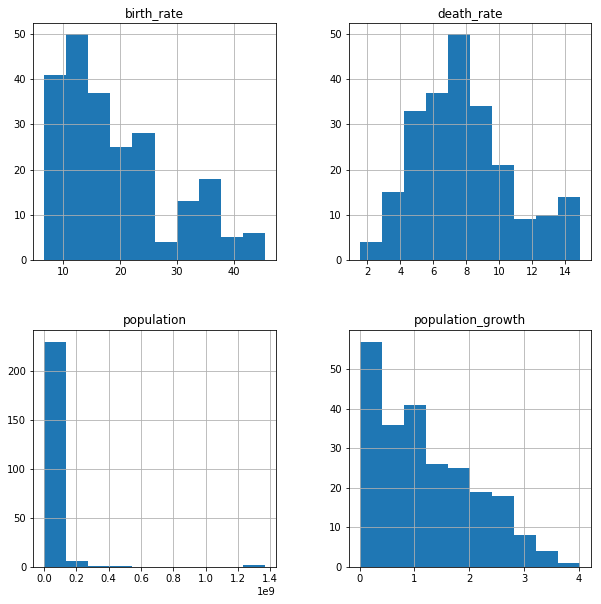

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

query = \
"SELECT population, \
        population_growth, \
        birth_rate, \
        death_rate \
FROM facts \
WHERE population != (SELECT MIN(population) FROM facts) AND \
      population != (SELECT MAX(population) FROM facts)"


# execute query and convert output into pandas dataframe
df = pd.read_sql_query(query, conn)

# create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# draw histogram
df.hist(ax=ax)

# 5. More questions

## Which countries have the highest population density?

Ten most populated countries will be displayed. The density is defined as the ratio of the population to the area of the land.

In [7]:
query = \
"SELECT name, \
        ROUND(CAST(population AS REAL) / CAST(area_land AS REAL), 2) AS Population_density \
FROM facts \
ORDER BY Population_density DESC \
LIMIT 10"

df = pd.read_sql_query(query, conn)

display(df)

,name,Population_density
0,Macau,21168.96
1,Monaco,15267.50
2,Singapore,8259.78
3,Hong Kong,6655.27
4,Gaza Strip,5191.82
5,Gibraltar,4876.33
6,Bahrain,1771.86
7,Maldives,1319.64
8,Malta,1310.02
9,Bermuda,1299.93


## Generate a histogram of population densities.

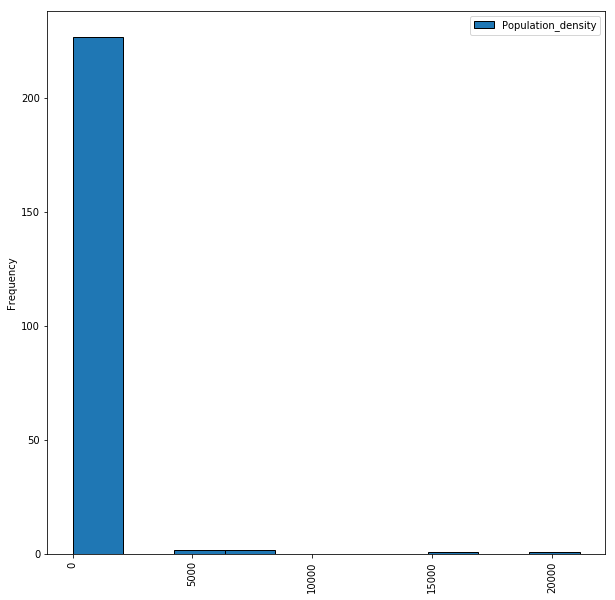

In [10]:
import numpy as np

query = \
"SELECT name, \
        ROUND(CAST(population AS REAL) / CAST(area_land AS REAL), 2) AS Population_density \
FROM facts \
ORDER BY Population_density DESC"

df = pd.read_sql_query(query, conn)

# create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# draw histogram
df.plot.hist(ax=ax, rot=90, edgecolor="k")

# TODO

## Which countries have the highest ratios of water to land? Which countries have more water than land?